## Добрый день.

Эта работа описывает создание линейного классификатора изображений cifar-10. 

В качестве модели выбрана логистическая регрессия, как наиболее понятная и воспроизводимая линейная модель.   
В основе работы лежит решение задачи многоклассовой классификации. Градиент ошибки вычислияется с помощью cross_entropy. 

Все основные расчеты выполнены с помощью библиотеки numpy.

### Загрузка данных

Загрузим библиотеки

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize
import pickle

import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [2]:
# sklearn используется в проекте в качестве проверочного решения
# все внутренные расчеты модели содержат numpy

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score

Создаем функцию загрузки и решейпа данных по батчам

In [3]:
def single_batch(file):

    with open(file, 'rb') as f_single_batch:
        d_single_batch = pickle.load(f_single_batch, encoding='latin1')  
        x = d_single_batch['data']  
        y = d_single_batch['labels'] 
        
        x = x.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1)        
        y = np.array(y)


        return x, y

Пробегаемся по батчам, создаем обучающую, валидационную и тестовую выборку.  
  
*При реране ноутбука на локальной машине - пожалуйста, скачайте и распакуйте датасет [cifar_10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) в любую папку. Далее - измените путь к данным в ячейке ниже.*

In [4]:
batches = ['data_batch_2', 'data_batch_3', 'data_batch_4']

x_train, y_train = single_batch('F:\\temp_pics\\cifar\\cifar-10-batches-py\\data_batch_1')
x_valid, y_valid = single_batch('F:\\temp_pics\\cifar\\cifar-10-batches-py\\data_batch_5')
x_test, y_test = single_batch('F:\\temp_pics\\cifar\\cifar-10-batches-py\\test_batch')


for batch in batches:
    
    x_new, y_new =  single_batch('F:\\temp_pics\\cifar\\cifar-10-batches-py\\' + batch)
    
    x_train = np.concatenate((x_train, x_new))
    y_train = np.concatenate((y_train, y_new))

In [5]:
print(x_train.shape, x_valid.shape, x_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)


Для проверки создадим список с названием классов

In [6]:
labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Выведем несколько образцов и посмотрим на них

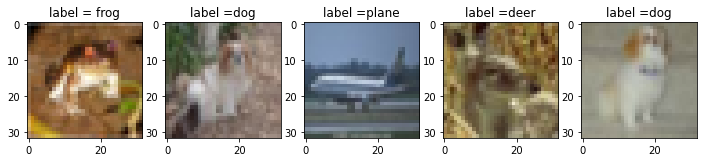

In [7]:
figure_1, ax = plt.subplots(1,5, figsize=(12,4))

ax[0].imshow(x_train[0])
ax[0].set_title('label = ' + labels[y_train[0]])
ax[1].imshow(x_train[1991])
ax[1].set_title('label =' + labels[y_train[1991]])
ax[2].imshow(x_train[21000])
ax[2].set_title('label =' + labels[y_train[21000]])
ax[3].imshow(x_valid[8878])
ax[3].set_title('label =' + labels[y_valid[8878]])
ax[4].imshow(x_test[1337])
ax[4].set_title('label =' + labels[y_test[1337]])
plt.show()

### Изменение размерности массивов и нормализация данных

Для удобства работы "схлопнем" массивы с размерностью 32х32х3 до 3072х1

In [8]:
x_train_flatten = x_train.reshape(x_train.shape[0], -1)
x_valid_flatten = x_valid.reshape(x_valid.shape[0], -1)
x_test_flatten = x_test.reshape(x_test.shape[0], -1)

print(x_train_flatten.shape, x_test_flatten.shape)

(40000, 3072) (10000, 3072)


Разделим каждый элемент массивов на 255. Заведем все значения в диапазон [0:1].

In [9]:
x_train_flatten[0]

array([ 59,  62,  63, ..., 123,  92,  72], dtype=uint8)

In [10]:
x_train_normalized = x_train_flatten / 255.0
x_valid_normalized = x_valid_flatten / 255.0
x_test_normalized = x_test_flatten / 255.0

In [11]:
x_train_normalized[0]

array([0.23137255, 0.24313725, 0.24705882, ..., 0.48235294, 0.36078431,
       0.28235294])

Для тестирования классификатора возьмем ограниченный набор данный. Для обучения, валидации и теста - по 1000. При бОльшем объем падает память локальной машины и вычисление экспонент стремится к бесконечности.

In [12]:
X_train = x_train_normalized[:1000]
y_train = y_train[:1000]

X_valid = x_valid_normalized[:1000]
y_valid = y_valid[:1000]

X_test = x_test_normalized[:1000]
y_test = y_test[:1000]

Проверим распределение лейблов в обучающей выборке.

In [13]:
temp = pd.Series(y_train)
temp.value_counts()

1    112
6    107
9    103
7    102
0    102
8     99
4     99
2     99
3     92
5     85
dtype: int64

Классы сбалансированы неидеально, но с невысоким уровнем дисперии. На точность прогноза в данном случае такое распределение не должно сильно повлиять. Выдвину гипотезу, что модель лучше всего будет предсказывать единички и шестерки, как господствующие классы.

### Бинаризация лейблов

Для мультиклассовой задачи необходимо перевести лейблы в бинарный вид. Вектор каждого лейбла будет иметь длинну, равную количеству классов. Вектор будет содержать нули и одну единицу, находящуюся на позиции номера класса.

In [14]:
def encoding(label):
    
    binary_labels = np.zeros((len(label), 10))
    
    for i in range(len(label)):    
        binary_label = [0,0,0,0,0,0,0,0,0,0]
        binary_label[label[i]] = 1
        binary_labels[i] = binary_label
        
    return binary_labels

### Softmax  

Напишем функцию, которая на вход получает предсказанные моделью числовые значения по каждому классу и возвращает вероятности принадлежности примера к определенному классу.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR7eTUTBwSQgnisOSR4f7BNWWsHHU2f7x66ug&usqp=CAU)

где в числителе $x_i$ - экспонента элемента входящего вектора,   
в знаменателе - сумма всех $x_j$ элементов входящего вектора, необходима для нормализации выходных значений.

Внесем небольшие изменения для стабильной работы функции с любой размерностью входязих чисел.

In [15]:
def softmax(x):
    # данный шаг позволит избежать чисел близких к inf (exponent overflow)
    e = np.exp(x - np.max(x))  
    
    if e.ndim == 1:
        return e / np.sum(e, axis=0)
    else:  
        return e / np.array([np.sum(e, axis=1)]).T  # ndim = 2

### Создание классификатора

Создадим новый класс и пропишем все необходимые функции.  

Синтаткис класса схож со sklearn. Основные операции - fit() для обучения, predict() и predict_proba() для предсказания лейбла и вероятности лейбла.  
Можно регулировать начальный learning rate, шаг изменения learning rate, количесво эпох обучения и строгость регуляризации.

На вход функция будет получать "развернутое" в двумерный массив изображение.

В модели используется l2 регуляризация для штрафа "пиковых" фич-значений яркости пикселя одного из трех цветов.

Для вычисления градиента ошибки (cost) выбран подход мультиклассовой классификации one-vs-rest. Модель вычисляет вероятность принадледности объекта к классу. Далее мы вычисляем кросс-энтропию и "кост" функции на каждой эпохе. 

Функция fit() обладает аргументом *verbose*. При *verbose*=True функция выводит список градиента ошибки. По умолчанию - аргумент = False. 

In [16]:
class Logistic_Regression_numpy(object):
    
    def __init__(self, input, label, lr=0.001):
        self.x = input
        self.y = encoding(label)
        self.lr = lr
        # устанавливаем начальные веса модели на нулевой массив
        self.W = np.zeros((self.x.shape[1], self.y.shape[1]))  
        # устанавливаем начальный bias на ноль
        self.b = np.zeros(self.y.shape[1])          

        self.params = [self.W, self.b, self.lr]

        
    # на вход fit() принимает количество эпох, которое может менять пользователь
    # показатель строгости регуляризации можно менять непосредственно в момент применения функции
    
    def fit(self, epochs, input=None, L2_reg=0.10, verbose=False):
        if input is not None:
            self.x = input
               
        cost_ = []
        
        for epoch in range(epochs):
            # расчитываем первый проход модели по данным. 
            # на первой итерации веса нулевые. новая эпоха == обновленный вес и bias
            # далее сравнимаем предсказанные значения с реальными
            p_y_given_x = softmax(np.dot(self.x, self.W) + self.b)
            d_y = self.y - p_y_given_x
        
            # обновляем веса модели с текущим значением learning rate и применяем регуляризацию для пиков
            self.W += self.lr * np.dot(self.x.T, d_y) - self.lr * L2_reg * self.W
            self.b += self.lr * np.mean(d_y, axis=0)
            
            # подсчитываем ошибку
            cost = self.negative_log_likelihood()           
            cost_.append(cost)
            
            # обновляем learning rate
            self.lr *= 0.95   
            
        if verbose == True:    
            return cost_
            
            
    # функция NLL и кросс-энтропии 
    
    def negative_log_likelihood(self):
        # первым шагом подаем софтмакс функции выход модели
        softmax_activation = softmax(np.dot(self.x, self.W) + self.b)
        # вторым шагом находим кросс-энтропию
        cross_entropy = - np.mean(
            np.sum(self.y * np.log(softmax_activation) +
            (1 - self.y) * np.log(1 - softmax_activation),
                      axis=1))
        
        return cross_entropy

    
    def predict(self, x):
        
        # подставляем новые фичи в модель с обновленными весами, learning rate и смещением
        output = softmax(np.dot(x, self.W) + self.b)
        prediction = []
        # перносим массивы ответов с вероятностями в лейблы
        for i in range(len(output)):
            y_i = np.argmax(output[i])
            prediction.append(y_i)
        
        return prediction
    
    
    def predict_proba(self, x):
        
        # укороченный вариант predict() здесь нам не надо выделять предсказанный лейбл класса
        output = softmax(np.dot(x, self.W) + self.b)
        
        return output

### Обучение и валидация результатов  

Создадим классификатор и обучим его на 500 эпохах (итерациях).

In [17]:
classifier_numpy = Logistic_Regression_numpy(X_train, y_train)

In [18]:
%%time
history = classifier_numpy.fit(epochs=500, verbose=True)

G:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log
G:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
G:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
G:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply


Wall time: 15.7 s


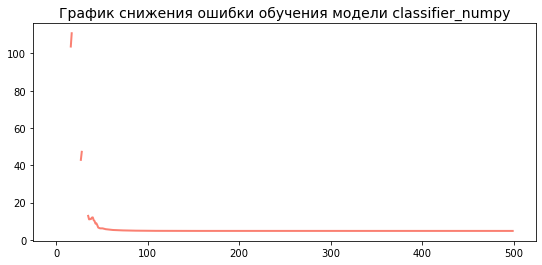

In [19]:
plt.figure(figsize=(9,4))
plt.plot(history, c='salmon', linewidth=2)
plt.title('График снижения ошибки обучения модели classifier_numpy', size=14);

Минимума функция достигает в диапазоне 70 эпох. На графике видны разрывы. Это ледствие ошибок умножения матриц в работе numpy. Локальные nan, которые появляются на некоторых эпохах, не влияют на общую работу алгоритма. При использовании данных меньшей размерности такой ошибки не обнаружено, график без разрывов.

Cоздадим функцию проверки качества работы нового класса.

In [20]:
def evaluation(model, x, y):
    
    prediction = model.predict(x)
    f1 = f1_score(y, prediction, average='macro')
    class_report = classification_report(y, prediction)
    
    print('f1-macro скор модели =', np.round(f1,4))
    print()
    print(class_report)

Проверим качество модели трех выборках.

In [21]:
evaluation(classifier_numpy, X_train, y_train)

f1-macro скор модели = 0.4464

              precision    recall  f1-score   support

           0       0.46      0.42      0.44       102
           1       0.52      0.52      0.52       112
           2       0.42      0.41      0.42        99
           3       0.38      0.39      0.39        92
           4       0.49      0.47      0.48        99
           5       0.45      0.45      0.45        85
           6       0.43      0.47      0.45       107
           7       0.35      0.33      0.34       102
           8       0.46      0.49      0.48        99
           9       0.50      0.50      0.50       103

    accuracy                           0.45      1000
   macro avg       0.45      0.45      0.45      1000
weighted avg       0.45      0.45      0.45      1000



In [22]:
evaluation(classifier_numpy, X_valid, y_valid)

f1-macro скор модели = 0.3111

              precision    recall  f1-score   support

           0       0.43      0.38      0.40       104
           1       0.36      0.34      0.35        94
           2       0.22      0.19      0.21        94
           3       0.19      0.17      0.18        88
           4       0.24      0.23      0.24       107
           5       0.19      0.22      0.21        96
           6       0.39      0.49      0.44       100
           7       0.24      0.21      0.22       103
           8       0.41      0.49      0.45       104
           9       0.44      0.41      0.42       110

    accuracy                           0.32      1000
   macro avg       0.31      0.31      0.31      1000
weighted avg       0.31      0.32      0.31      1000



In [23]:
evaluation(classifier_numpy, X_test, y_test)

f1-macro скор модели = 0.2974

              precision    recall  f1-score   support

           0       0.34      0.33      0.33       103
           1       0.37      0.37      0.37        89
           2       0.18      0.15      0.16       100
           3       0.19      0.17      0.18       103
           4       0.20      0.22      0.21        90
           5       0.22      0.23      0.23        86
           6       0.38      0.41      0.40       112
           7       0.28      0.28      0.28       102
           8       0.43      0.47      0.45       106
           9       0.38      0.36      0.37       109

    accuracy                           0.30      1000
   macro avg       0.30      0.30      0.30      1000
weighted avg       0.30      0.30      0.30      1000



1. Точность прогноза далека от идеала;
2. Заметно переобучение; 
3. Модель предсказывает каждый класс. Нулевые предсказания классов отсутствуют;  
4. Качество предсказаний на валидационном и тестовом сете похожи. Модель обучилась.

Однако, посмотрим, что сможет показать логистическая регрессия из коробки от sklearn. Для чистоты эксперимента не будем сильно тюнить гиперпараметры.

In [24]:
%%time
classifier_sklearn = LogisticRegression(C=0.01, solver='lbfgs', multi_class='auto', max_iter=500, random_state=1337)
classifier_sklearn.fit(X_train, y_train)

Wall time: 10.1 s


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1337, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
evaluation(classifier_sklearn, X_train, y_train)

f1-macro скор модели = 0.5815

              precision    recall  f1-score   support

           0       0.62      0.60      0.61       102
           1       0.62      0.69      0.65       112
           2       0.54      0.54      0.54        99
           3       0.60      0.45      0.51        92
           4       0.69      0.53      0.60        99
           5       0.57      0.51      0.54        85
           6       0.51      0.65      0.58       107
           7       0.58      0.57      0.57       102
           8       0.61      0.67      0.64        99
           9       0.55      0.62      0.58       103

    accuracy                           0.58      1000
   macro avg       0.59      0.58      0.58      1000
weighted avg       0.59      0.58      0.58      1000



In [26]:
evaluation(classifier_sklearn, X_valid, y_valid)

f1-macro скор модели = 0.3114

              precision    recall  f1-score   support

           0       0.39      0.43      0.41       104
           1       0.34      0.37      0.36        94
           2       0.24      0.22      0.23        94
           3       0.19      0.11      0.14        88
           4       0.28      0.21      0.24       107
           5       0.15      0.14      0.14        96
           6       0.38      0.53      0.44       100
           7       0.36      0.30      0.33       103
           8       0.35      0.45      0.39       104
           9       0.40      0.45      0.42       110

    accuracy                           0.33      1000
   macro avg       0.31      0.32      0.31      1000
weighted avg       0.31      0.33      0.32      1000



In [27]:
evaluation(classifier_sklearn, X_test, y_test)

f1-macro скор модели = 0.3217

              precision    recall  f1-score   support

           0       0.41      0.39      0.40       103
           1       0.42      0.48      0.45        89
           2       0.22      0.22      0.22       100
           3       0.20      0.13      0.15       103
           4       0.24      0.19      0.21        90
           5       0.22      0.16      0.19        86
           6       0.34      0.49      0.40       112
           7       0.34      0.33      0.34       102
           8       0.42      0.48      0.45       106
           9       0.39      0.42      0.41       109

    accuracy                           0.34      1000
   macro avg       0.32      0.33      0.32      1000
weighted avg       0.32      0.34      0.33      1000



### Сравнение результатов

Сведем результаты в общую таблицу.

In [36]:
models = ['numpy', 'sklearn']
time = [15.7, 10.1]
train_score = [0.446, 0.582]
valid_score = [0.311, 0.311]
test_score = [0.297, 0.322]

dict_ = {'algorithm':models,
         'training time':time, 
         'f1_train':train_score,
         'f1_valid':valid_score,
         'f1_test':test_score
        }

result = pd.DataFrame(data=dict_)

In [37]:
result

,algorithm,training time,f1_train,f1_valid,f1_test
0,numpy,15.7,0.446,0.311,0.297
1,sklearn,10.1,0.582,0.311,0.322


"Ручная" заметно проигрывает по времени обучения коробочному решению. Однако показывает очень близкий результат в предсказаниях на вализационной и тестовой выборках. Так же можно заметно меньшее переобучение модели, написанной на numpy.

### Предсказание единичного изображения.

In [30]:
print('test\n' 'test')

test
test


In [31]:
def predict_example(model, x, y):
    
    x_pred = x.reshape(32*32*3, -1).T / 255.0
    prediction = int(model.predict(x_pred)[0])
    # танцы с бубном для того, чтобы не перепесывать encoding под одиночный пример
    y_pred = []
    y_pred.append(y)
    y_pred = encoding(y_pred)
    
    label_true = labels[y]
    label_pred = labels[prediction]
    
    plt.figure(figsize=(3,3))
    plt.imshow(x)
    print('true_label:', label_true)
    print('pred_label:', label_pred)

true_label: plane
pred_label: plane


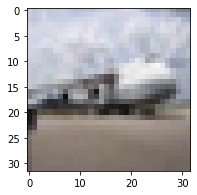

In [32]:
predict_example(classifier_numpy, x_valid[818], y_valid[818])

true_label: dog
pred_label: truck


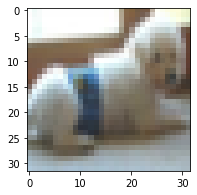

In [33]:
predict_example(classifier_numpy, x_valid[373], y_valid[373])

Самолет распознали. А вот с собачкой неловко вышло.

### Вывод

Цель работы достигнута - создана модель многоклассовой классификации на основе numpy.  
Классификатор обладает относительно невысоким качеством прогноза: f1-macro ~0.3 на валидационной и тестовой выборках. Но данный показатель близок к коробочному решению sklearn: f1-macro ~0,33.

Для дальнейшего повышения качества прогнозов можно применить снижение размерности массивов (PCA), поиграть со скруткой многомерного массива, применять более сложные модели.